# Handwritten Postal Codes

__Convolutional Neural Networks__

_By Marnick van der Arend & Jeroen Smienk_

![Sample Digits](digits-sample.png)

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

__MODEL_PATH = 'conv_models'
__DATA_PATH = 'dataset-images'
__TENSOR_LOG_DIR = 'conv-logs'

__LABELS = 10
__IM_SIZE = 32
__N_DIGITS = 4

## Dataset

480 Images consisting of 4 digit postal codes with the label as the file name e.g. `3365.png`.

In [56]:
def binarize(image):
    """
    Returns a binarized image where lighter values are set to 255 and the lower values set to 0.
    """
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def crop(image):
    """
    Crop an 128x32 image to 4 32x32 images
    """
    digits = []
    x,y,w,h = 0,0,__IM_SIZE,__IM_SIZE
    for i in range(__N_DIGITS):
        x = i*w
        digits.append(image[y:y+h, x:x+w])
    return digits

def get_images_in_path(path, extension):
    """
    Create a list of all images and their file names (labels) in a certain path
    """
    images = []
    labels = []
    for name in os.listdir(path):
        if name.endswith(extension):
            img = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
            label = name[:-len(extension)] # remove extension
            digits = crop(binarize(img))
            for i in range(__N_DIGITS):
                images.append(digits[i])
                labels.append(int(label[i]))
    return np.array(images, dtype=np.int32), np.array(labels, dtype=np.int32)

### Creating the dataset

We split the 480 images in 1920 individual black-and-white digits and save them with their correct label as a tuple in a list. We also binarize the images so there is less noise in the images.

In [57]:
images, labels = get_images_in_path(__DATA_PATH, '.png')

Let's see what kind of digits are in the set by plotting them with their labels:

Size of dataset: 1920 images


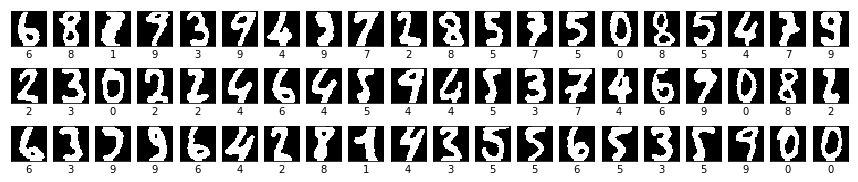

In [58]:
print("Size of dataset: {len} images".format(len=len(images)))

PLOT_SIZE = 60
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(labels[i])
    plt.imshow(images[i], cmap=plt.cm.binary)

#### One-Hot Eencoding

To compare the labels with the predictions of the neural network we need to 'one-hot' encode the labels:

The index of the `1` is the correct label of the data.

In [59]:
onehot = np.zeros((len(labels), __LABELS))
onehot[range(len(labels)), labels] = 1

print('One hot encoded labels:')
print(onehot[:5])

One hot encoded labels:
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


We combine the data and the labels to be able to shuffle them without forgetting which labels belong to which images.

In [68]:
data = np.array([np.array([images[i], onehot[i]]) for i in range(len(images))])

In [69]:
shuffled_data = np.random.permutation(data)

X = np.array([x[0] for x in shuffled_data])
X = np.reshape(X, (len(X), 32, 32, 1))
Y = np.array([x[1] for x in shuffled_data])

print('Images shape: {}'.format(X.shape))
print('Labels shape: {}'.format(Y.shape))

Images shape: (1920, 32, 32, 1)
Labels shape: (1920, 10)


We split the data into train, test, and validation sets.

We use the train set to train; the test set to cross-validate during training; and the validation set to validate the model after the model is done training.

In [70]:
split = int(len(X) * .85)
X_train = X[:split]
X_valid = X[split:]
Y_train = Y[:split]
Y_valid = Y[split:]

split = int(len(X_train) * .85)
X_test = X_train[split:]
X_train = X_train[:split]
Y_test = Y_train[split:]
Y_train = Y_train[:split]

print('Split X (train, test, validation):', X_train.shape, X_test.shape, X_valid.shape)
print('Split Y (train, test, validation):', Y_train.shape, Y_test.shape, Y_valid.shape)

Split X (train, test, validation): (1387, 32, 32, 1) (245, 32, 32, 1) (288, 32, 32, 1)
Split Y (train, test, validation): (1387, 10) (245, 10) (288, 10)


We define a function that returns a random batch of a certain size. This batch is used in training to let the model more easily adapt to the data.

In [71]:
def get_batch(x, y, size):
    batch = np.array([(x[i], y[i]) for i in range(len(x))])
    random_batch = np.random.permutation(batch)[:size]
    return np.array([x[0] for x in random_batch]), np.array([x[1] for x in random_batch])

## Models

We designed several models:

rank | name | layers | score
--- | --- | --- | ---
5 | model_8 | (64, Tanh, Drop=.2) (128, Tanh, Drop=.3) (256, Tanh, Drop=.4) (512, Tanh, Drop=.5) (64, Tanh) | 0.93714285
4 | model_7 | (64, ReLU) (128, ReLU) (256, ReLU) (512, ReLU, Drop=.3) (64, ReLU) | 0.94057140
3 | model_6 | (200, Tanh) (300, Tanh) (600, Tanh) | 0.97828573
1 | model_5_2 | (600, Tanh, Drop=.3) (300, Tanh, Drop=.3) (200, Tanh, Drop=.3) | 0.98742855
2 | model_5 | (600, Tanh) (300, Tanh) (200, Tanh) | 0.97942860
6 | model_4 | (128, Tanh) (64, Tanh) (32, Tanh) | 0.87771430
7 | model_3 | (12, ReLU) (24, ReLU) (48, ReLU, Drop=.1) (96, ReLU) | 0.73028570
8 | model_2 | (128, ReLU) (64, ReLU) (32, ReLU) | 0.82400000
9 | model_1 | (128, Sigmoid) | 0.66628570

Dropout has a positive effect on the score as can be seen in the table. We also found that the tanh activation function performed well. 

- Model 1: BLUE
- Model 2: RED
- Model 3: LIGHT BLUE
- Model 4: PINK
- Model 5: GREEN
- Model 6: GRAY
- Model 7: ORANGE
- Model 8: ORANGE

### Batch Accuracy


### Batch Loss


In [72]:
def model_1(x, output_shape):
    """
    One Conv2d layer with a kernel size of 3 and 
    """
    l_1 = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding="same", 
                           activation=tf.nn.relu)
    return tf.layers.dense(l_1, units=output_shape, activation=None)

In [73]:
def model_2(x, output_shape):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=5, 
                             padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=2)
    
    flatten = tf.contrib.layers.flatten(pool1)
    return tf.layers.dense(flatten, units=output_shape, activation=None)

In [74]:
def model_3(x, output_shape):
    """
    """
    #32 convolution filters used each of size 3x3
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    #64 convolution filters used each of size 3x3
    conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size = 3,
                         strides = 1, padding="valid",
                         activation = tf.nn.relu)
    
    #choose the best features via pooling
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    
    #randomly turn neurons on and off to improve convergence
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    #flatten since too many dimensions, we only want a classification output
    flatten = tf.contrib.layers.flatten(dropout1)

    #fully connected to get all relevant data
    dense = tf.layers.dense(flatten, units=128, activation=tf.nn.relu)
    
    #one more dropout for convergence' sake :) 
    dropout2 = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout2, units=output_shape, activation=None)

In [75]:
def model_4(x, output_shape):
    """
    IMPLEMENT BATCH NORMALIZATION AFTER CONV LAYERS
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
        
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)

    conv3 = tf.layers.conv2d(pool1, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)

    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2)

    flatten = tf.contrib.layers.flatten(pool2)

    # Fully connected layer
    dense = tf.layers.dense(flatten, units=512, activation=tf.nn.relu)

    dropout = tf.layers.dropout(dense, rate=.2)
    
    return tf.layers.dense(dropout, units=output_shape, activation=None)

In [84]:
def model_5(x, output_shape):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    conv3 = tf.layers.conv2d(x, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2)
    dropout2 = tf.layers.dropout(pool2, rate=.25)
    
    flatten = tf.contrib.layers.flatten(dropout2)
    dense = tf.layers.dense(flatten, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout, units=output_shape, activation=None)

We start with the placeholder for our 5-dice input and 7-class output and choose a model:

In [87]:
x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], 1], name='x')
y = tf.placeholder(tf.float32, shape=[None, Y_train.shape[1]], name='y')

model_fn = model_5
y_pred = model_fn(x, Y_train.shape[1])

## Training

We choose an optimizer, a loss functon and metrics:

In [92]:
# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)
loss_fn = tf.reduce_mean(cross_entropy)

# Optimizer minimizes the loss
# optimizer = tf.train.AdamOptimizer(learning_rate=.0005).minimize(loss_fn)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss_fn)

# Accuracy metric
#   checks if the indices of the highest values in the real 
#   and predicted arrays are equal
prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

We train the model using a certain batch size and for a number of iterations while posting scalars to TensorBoard:

In [93]:
iters = 1500
train_batch_size = 20

session = tf.Session()
with session:
    session.run(tf.global_variables_initializer())

    sum_loss_train = tf.summary.scalar('loss_train', loss_fn)
    sum_loss_test = tf.summary.scalar('loss_test', loss_fn)
    sum_acc_train = tf.summary.scalar('acc_train', accuracy)
    sum_acc_test = tf.summary.scalar('acc_test', accuracy)
    tf.summary.merge_all()
    writer = tf.summary.FileWriter(os.path.join(__TENSOR_LOG_DIR, model_fn.__name__), session.graph)
    
    for i in range(iters):
        x_batch, y_batch = get_batch(X_train, Y_train, train_batch_size)
                
        loss_val, _, acc_val, sum_1, sum_2 = session.run([loss_fn, optimizer, accuracy, 
                                                          sum_loss_train, sum_acc_train], 
                                                         feed_dict={x: x_batch, y: y_batch})

        writer.add_summary(sum_1, global_step=i)
        writer.add_summary(sum_2, global_step=i)
    #     print('Training - i:', i+1, 'Loss:', loss_val, 'Accuracy:', acc_val)

        # Validate every 50 iterations
        if i % 50 == 0:
            acc_val, sum_1, sum_2 = session.run([accuracy, sum_loss_test, sum_acc_test], 
                                                feed_dict={x: X_test, y: Y_test})

            writer.add_summary(sum_1, global_step=i)
            writer.add_summary(sum_2, global_step=i)
            print('Validation - i:', i+1, ' Accuracy:', acc_val)
    

    # Validate the model with unseen data
    acc_val = session.run([accuracy], feed_dict={x: X_valid, y: Y_valid})

    # Print test metrics
    print('Accuracy:', acc_val)

Validation - i: 1  Accuracy: 0.12244898
Validation - i: 51  Accuracy: 0.7673469
Validation - i: 101  Accuracy: 0.89387757
Validation - i: 151  Accuracy: 0.93877554
Validation - i: 201  Accuracy: 0.955102
Validation - i: 251  Accuracy: 0.955102
Validation - i: 301  Accuracy: 0.93061227
Validation - i: 351  Accuracy: 0.955102
Validation - i: 401  Accuracy: 0.9632653
Validation - i: 451  Accuracy: 0.9755102
Validation - i: 501  Accuracy: 0.9510204
Validation - i: 551  Accuracy: 0.955102
Validation - i: 601  Accuracy: 0.9632653
Validation - i: 651  Accuracy: 0.9632653
Validation - i: 701  Accuracy: 0.94285715
Validation - i: 751  Accuracy: 0.93061227
Validation - i: 801  Accuracy: 0.9632653
Validation - i: 851  Accuracy: 0.9755102
Validation - i: 901  Accuracy: 0.96734697
Validation - i: 951  Accuracy: 0.9714286
Validation - i: 1001  Accuracy: 0.9591837
Validation - i: 1051  Accuracy: 0.955102
Validation - i: 1101  Accuracy: 0.9346939
Validation - i: 1151  Accuracy: 0.9510204
Validation - 

## Validation

We validate the model with the data it has not seen yet:

In [ ]:
# with session:
#     # Validate the model with unseen data
#     acc_val = session.run([accuracy], feed_dict={x: X_valid, y: Y_valid})

#     # Print test metrics
#     print('Accuracy:', acc_val)

## Exporting & Importing

In [ ]:
save_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, model_fn.__name__, model_fn.__name__))

model_to_load = model_5_2

load_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, model_to_load.__name__, model_to_load.__name__))

We save the model that worked best:

In [ ]:
# with session:
#     tf.train.Saver().save(session, save_path)

We load the model that worked best:

In [ ]:
with tf.Session() as saved_session:
    tf.train.Saver().restore(saved_session, load_path)

    # Validate the model with unseen data
    acc_val = saved_session.run([accuracy], feed_dict={x: X_valid, y: Y_valid})

    # Print test metrics
    print('Accuracy:', acc_val)

## Conclusion